In [5]:
# Функция для расчета скользящих средних
def calculate_moving_averages(data, window):
    data['SMA_' + str(window)] = data['Цена'].rolling(window=window).mean()  # Простое скользящее среднее
    data['EMA_' + str(window)] = data['Цена'].ewm(span=window, adjust=False).mean()  # Экспоненциальное скользящее среднее
    return data
# Функция для расчета RSI
def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

# Функция для расчета MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# Загрузка данных
data_lkoh = pd.read_csv('data/Прошлые данные - INGR.csv')
# Убираем суффиксы "K" из столбца "Объём"
data_lkoh['Объём'] = data_lkoh['Объём'].str.replace('M', '000000').str.replace('K', '000')

data_lkoh['Изм. %'] = data_lkoh['Изм. %'].str.replace('%', '')

# Преобразование типов данных с учетом разделителей тысяч и возможных десятичных запятых
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])
data_lkoh['Цена'] = pd.to_numeric(data_lkoh['Цена'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Откр.'] = pd.to_numeric(data_lkoh['Откр.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Макс.'] = pd.to_numeric(data_lkoh['Макс.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Мин.'] = pd.to_numeric(data_lkoh['Мин.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Объём'] = pd.to_numeric(data_lkoh['Объём'].str.replace('.', '').str.replace(',', ''))
data_lkoh['Изм. %'] = pd.to_numeric(data_lkoh['Изм. %'].str.replace(',', '.'))

C:\Users\User\AppData\Local\Temp\ipykernel_13308\2020275461.py:11: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])


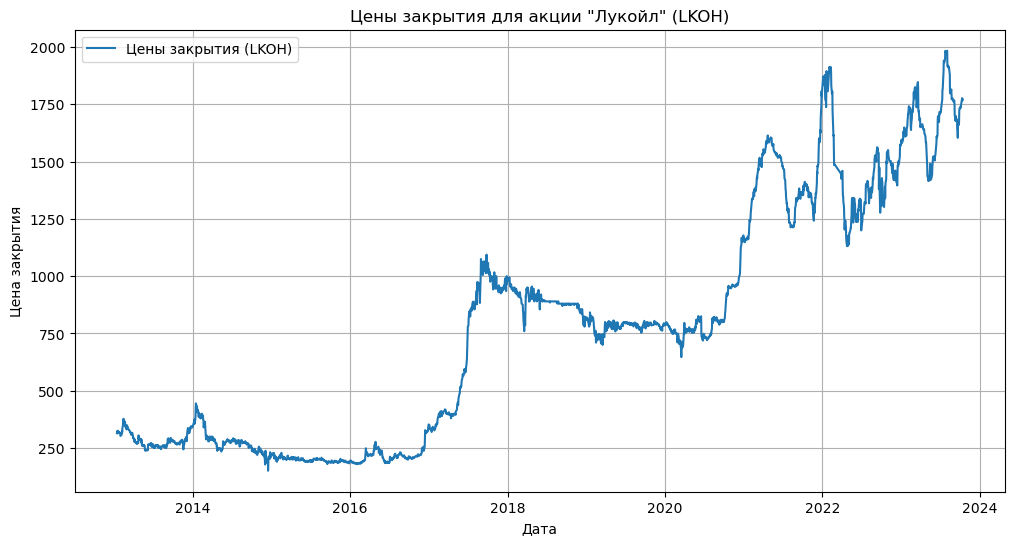

In [7]:
import matplotlib.pyplot as plt

# Построение графика цен закрытия для акции "Лукойл" (LKOH)
plt.figure(figsize=(12, 6))
plt.plot(data_lkoh['Дата'], data_lkoh['Цена'], label='Цены закрытия (LKOH)')
plt.title('Цены закрытия для акции "Лукойл" (LKOH)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.show()


In [8]:

df = data_lkoh
df['dayofweek'] = df['Дата'].dt.dayofweek
df['quarter'] = df['Дата'].dt.quarter
df['month'] = df['Дата'].dt.month
df['year'] = df['Дата'].dt.year
df['dayofyear'] = df['Дата'].dt.dayofyear
df['dayofmonth'] = df['Дата'].dt.day
df['weekofyear'] = df['Дата'].dt.isocalendar().week
# Выберите начальную дату (например, первая дата в вашем наборе данных)
start_date = data_lkoh['Дата'].min()

# Рассчитайте количество дней от начальной даты для каждой строки
data_lkoh['timestamp'] = (data_lkoh['Дата'] - start_date).dt.days

In [9]:

# Расчет признаков
data_lkoh = calculate_moving_averages(data_lkoh, window=20)  # Пример: 20-дневные скользящие средние
data_lkoh = calculate_rsi(data_lkoh)
data_lkoh = calculate_macd(data_lkoh)
# Interpolate missing values for 'RSI' and 'SMA_20' columns
data_lkoh['RSI'].interpolate(inplace=True)
data_lkoh['SMA_20'].interpolate(inplace=True)

# Check for remaining missing values
missing_values = data_lkoh.isnull().sum()
missing_values

Дата            0
Цена            0
Откр.           0
Макс.           0
Мин.            0
Объём           0
Изм. %          0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
timestamp       0
SMA_20         19
EMA_20          0
RSI            13
MACD            0
Signal_Line     0
dtype: int64

In [13]:
data_lkoh = data_lkoh.sort_index(ascending=False)
data_lkoh = data_lkoh.reset_index(drop=True)
data_lkoh
# Сдвигаем цену на следующий день
data_lkoh['Target'] = data_lkoh['Цена'].shift(-1)

# Удаляем последнюю строку, так как у нее не будет цены на следующий день
data_lkoh.dropna(inplace=True)

# Посмотрим на обновленный датасет
data_lkoh.head()


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,dayofweek,quarter,month,...,dayofyear,dayofmonth,weekofyear,timestamp,SMA_20,EMA_20,RSI,MACD,Signal_Line,Target
0,2023-09-18,1674.0,1682.0,1710.0,1671.0,743000,-0.71,0,3,9,...,261,18,38,3899,1710.30,1696.261218,33.928571,-32.396415,-26.304680,1686.0
1,2023-09-15,1686.0,1672.0,1698.0,1669.0,1254000,0.54,4,3,9,...,258,15,37,3896,1706.00,1695.283959,38.938053,-29.127049,-26.869154,1677.0
2,2023-09-14,1677.0,1690.0,1691.0,1661.0,1716000,-0.95,3,3,9,...,257,14,37,3895,1701.60,1693.542630,36.909871,-26.951597,-26.885643,1693.0
3,2023-09-13,1693.0,1696.0,1715.0,1678.0,782000,-0.35,2,3,9,...,256,13,37,3894,1697.40,1693.490951,40.725806,-23.663688,-26.241252,1699.0
4,2023-09-12,1699.0,1676.0,1720.0,1673.0,768000,1.31,1,3,9,...,255,12,37,3893,1693.95,1694.015622,43.319838,-20.339387,-25.060879,1677.0


In [12]:
data = data_lkoh[['Target']]
train_size = int(len(data) * 0.8)
# scaler = MinMaxScaler(feature_range=(0,1))
# data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1, 1))